✅ تم تحميل الـ scaler المحفوظ.
✅ تم تحميل العتبة المثلى: 0.715
✅ تم تحميل النموذج بنجاح.
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step

                    ECG CLASSIFICATION TEST REPORT                    

Sample    True Label     Predicted      Confidence     Status    
----------------------------------------------------------------------
1         abnormal       abnormal       100.0         %✅         
2         abnormal       abnormal       100.0         %✅         
3         normal         normal         99.8          %✅         
4         normal         normal         99.2          %✅         
5         abnormal       abnormal       100.0         %✅         
6         abnormal       abnormal       100.0         %✅         
7         normal         normal         100.0         %✅         
8         normal         normal         39.3          %✅         
9         abnormal       abnormal       100.0         %✅         
10        normal         normal         98.3          %✅         
1

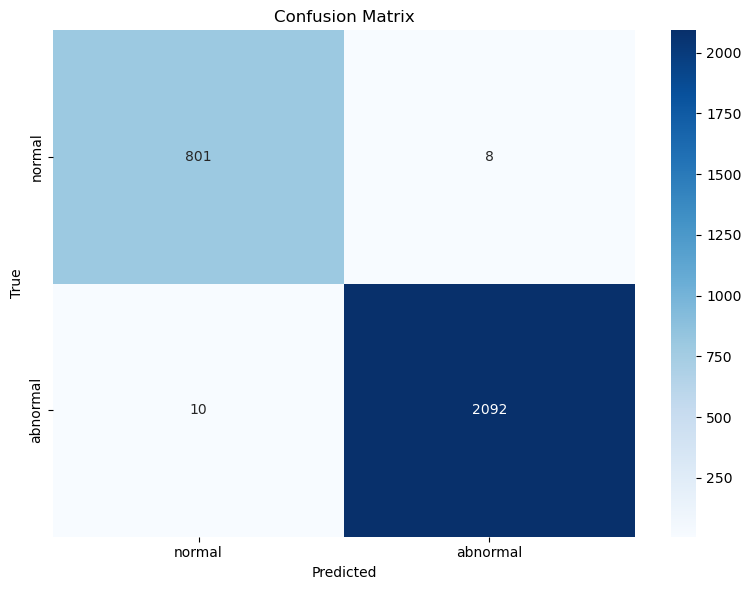

C:\Users\HP\AppData\Local\Temp\ipykernel_13088\383379953.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


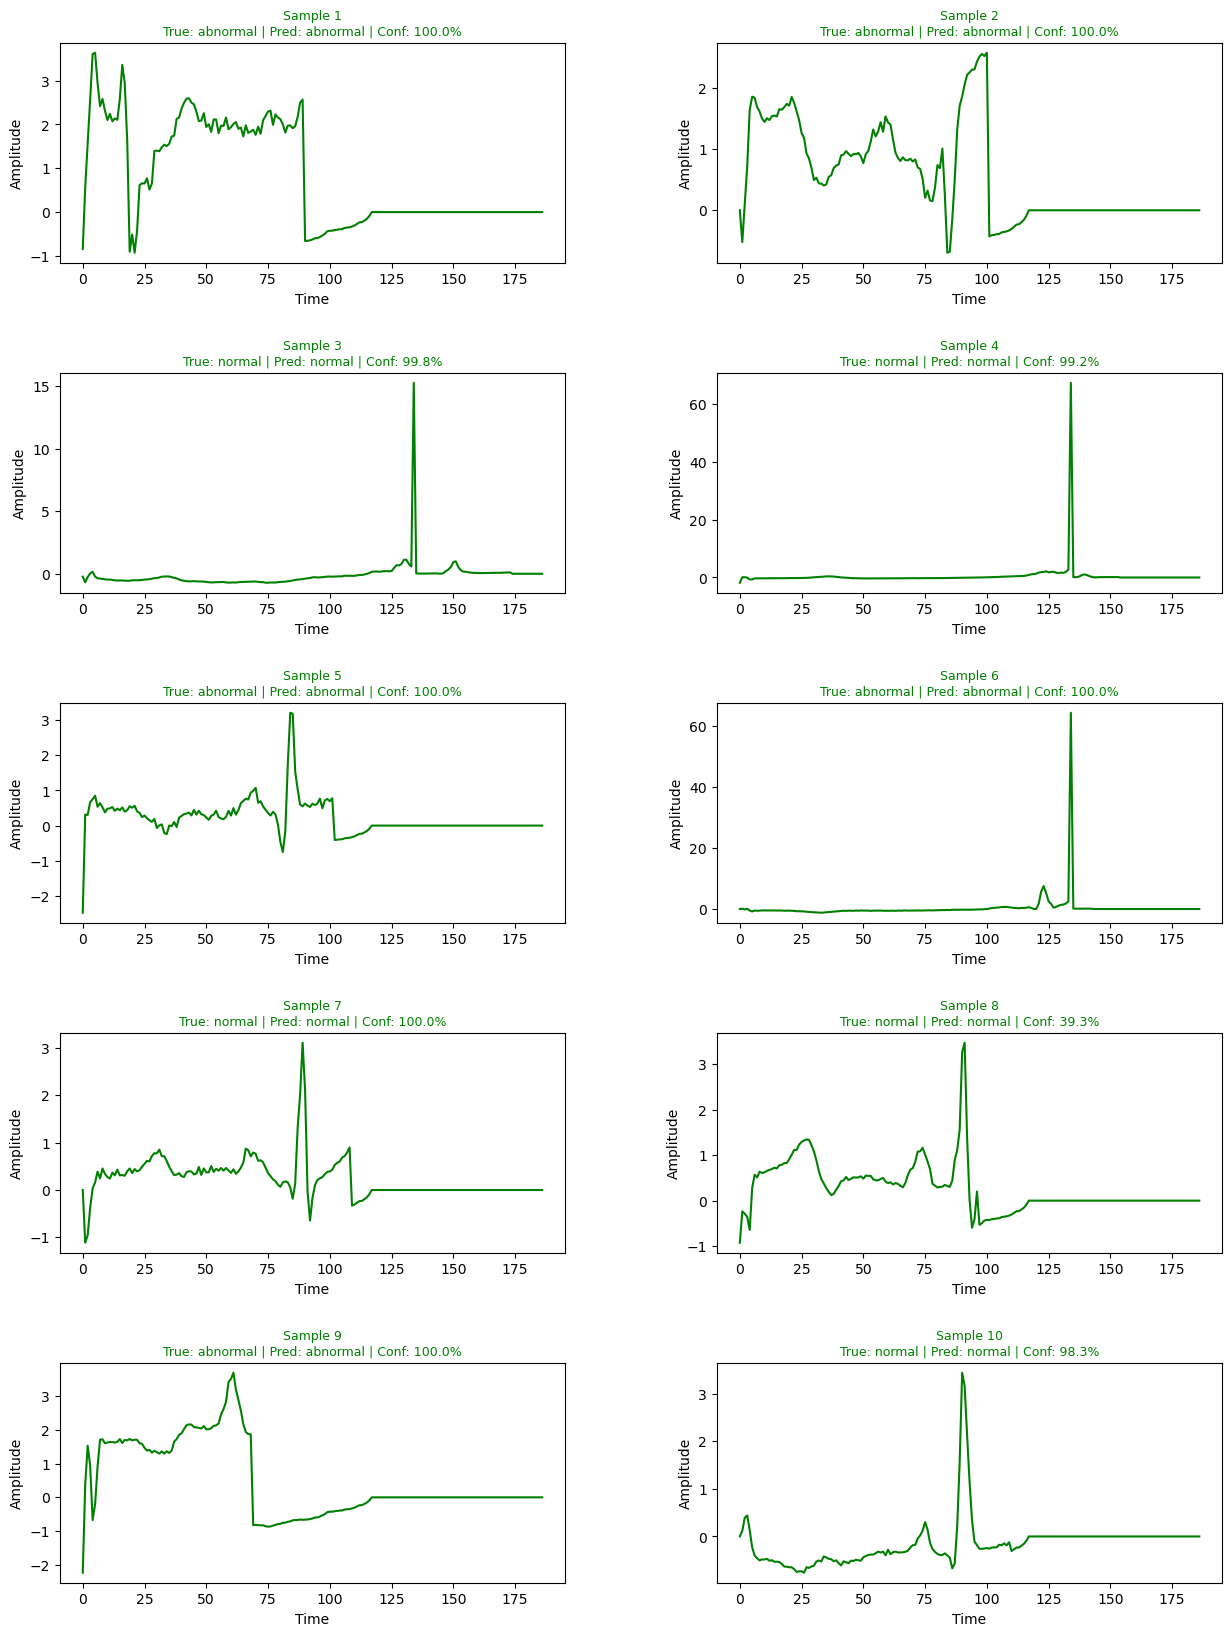

C:\Users\HP\AppData\Local\Temp\ipykernel_13088\383379953.py:169: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



✅ اختبار Enhanced Hybrid CNN-LSTM تم بنجاح!
📁 تم حفظ التقرير في: D:/upworkhealt/reports\ecg_test_report.pdf
📊 تم حفظ الرسومات في مجلد: D:/upworkhealt/reports


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.preprocessing import RobustScaler
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from matplotlib import gridspec
from matplotlib.backends.backend_pdf import PdfPages
import joblib

# ==== إعداد المسارات ====
DATA_PATH = r"D:/upworkhealt/data"
MODEL_PATH = r"C:/Users/HP/Desktop/upworkhealt/saved_models/enhanced_hybrid_cnn_lstm_final.keras"
SCALER_PATH = r"C:/Users/HP/Desktop/upworkhealt/saved_models/enhanced_scaler.save"
THRESHOLD_PATH = r"C:/Users/HP/Desktop/upworkhealt/saved_models/optimal_threshold.txt"
REPORT_FOLDER = r"D:/upworkhealt/reports"
os.makedirs(REPORT_FOLDER, exist_ok=True)

# ==== تحميل البيانات الأصلية ====
df_normal = pd.read_csv(os.path.join(DATA_PATH, "ptbdb_normal.csv"), header=None)
df_abnormal = pd.read_csv(os.path.join(DATA_PATH, "ptbdb_abnormal.csv"), header=None)
df_full = pd.concat([df_normal, df_abnormal])
df_full = shuffle(df_full, random_state=42)

# ==== فصل البيانات إلى ميزات وتسميات ====
X_full = df_full.iloc[:, :-1].values[:, :187]  # استخدم فقط أول 187 نقطة
y_full = df_full.iloc[:, -1].values.astype(int)

# ==== تقسيم البيانات إلى تدريب واختبار ====
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

# ==== تحميل الـ scaler المحفوظ ====
if os.path.exists(SCALER_PATH):
    scaler = joblib.load(SCALER_PATH)
    print("✅ تم تحميل الـ scaler المحفوظ.")
else:
    print("⚠️ ملف الـ scaler غير موجود! يرجى تدريب النموذج أو حفظ الـ scaler أولاً.")
    exit(1)

# ==== تحميل العتبة المثلى ====
if os.path.exists(THRESHOLD_PATH):
    with open(THRESHOLD_PATH, 'r') as f:
        threshold = float(f.read().strip())
    print(f"✅ تم تحميل العتبة المثلى: {threshold:.3f}")
else:
    print("⚠️ ملف العتبة المثلى غير موجود! سيتم استخدام 0.5 كعتبة افتراضية.")
    threshold = 0.5

# ==== تطبيق التوحيد ====
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ==== إعادة تشكيل للإدخال المناسب للنموذج (عينات, 187, 1) ====
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], 187, 1)
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], 187, 1)

# ==== تحميل النموذج ====
try:
    model = load_model(MODEL_PATH)
    print("✅ تم تحميل النموذج بنجاح.")
except Exception as e:
    print(f"❌ فشل تحميل النموذج: {e}")
    exit(1)

# ==== اختبار النموذج على بيانات الاختبار ====
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > threshold).astype(int).flatten()

# ==== تحضير التصنيفات النصية والثقة ====
y_true_text = ['abnormal' if y == 1 else 'normal' for y in y_test]
y_pred_text = ['abnormal' if y == 1 else 'normal' for y in y_pred]

confidence_scores = []
for i, prob in enumerate(y_pred_prob):
    pred_class = y_pred[i]
    confidence = prob[0] if pred_class == 1 else 1 - prob[0]
    confidence_scores.append(confidence * 100)

# ==== طباعة التقرير ====
print("\n" + "="*70)
print("ECG CLASSIFICATION TEST REPORT".center(70))
print("="*70 + "\n")
print(f"{'Sample':<10}{'True Label':<15}{'Predicted':<15}{'Confidence':<15}{'Status':<10}")
print("-"*70)

correct = 0
for i in range(len(X_test_scaled)):
    status = "✅" if y_true_text[i] == y_pred_text[i] else "❌"
    if status == "✅":
        correct += 1
    print(f"{i+1:<10}{y_true_text[i]:<15}{y_pred_text[i]:<15}{confidence_scores[i]:<14.1f}%{status:<10}")

accuracy = accuracy_score(y_test, y_pred) * 100
print(f"\nOverall Accuracy: {accuracy:.1f}% ({correct}/{len(X_test_scaled)})")

print("\nClassification Report:\n")
print(classification_report(y_true_text, y_pred_text, target_names=['normal', 'abnormal']))

# ==== رسم مصفوفة الالتباس ====
cm = confusion_matrix(y_true_text, y_pred_text, labels=['normal', 'abnormal'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['normal', 'abnormal'], yticklabels=['normal', 'abnormal'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig(os.path.join(REPORT_FOLDER, 'confusion_matrix.png'))
plt.show()

# ==== رسم إشارات ECG مع التلوين حسب الخطأ أو الصح ====
plt.figure(figsize=(15, 20))
gs = gridspec.GridSpec(5, 2, hspace=0.5, wspace=0.3)
for i in range(min(len(X_test_scaled), 10)):  # نعرض فقط أول 10 عينات
    ax = plt.subplot(gs[i])
    signal = X_test_scaled[i].squeeze()
    color = 'green' if y_true_text[i] == y_pred_text[i] else 'red'
    ax.plot(signal, color=color)
    ax.set_title(f"Sample {i+1}\nTrue: {y_true_text[i]} | Pred: {y_pred_text[i]} | Conf: {confidence_scores[i]:.1f}%",
                 fontsize=9, color=color)
    ax.set_xlabel("Time")
    ax.set_ylabel("Amplitude")
plt.tight_layout()
plt.savefig(os.path.join(REPORT_FOLDER, 'ecg_predictions_grid.png'))
plt.show()

# ==== إنشاء تقرير PDF متكامل ====
pdf_path = os.path.join(REPORT_FOLDER, 'ecg_test_report.pdf')
with PdfPages(pdf_path) as pdf:
    # صفحة العنوان
    plt.figure(figsize=(11, 8.5))
    plt.text(0.5, 0.7, 'ECG Classification Test Report', ha='center', va='center', fontsize=20, fontweight='bold')
    plt.text(0.5, 0.6, f'Model: Enhanced Hybrid CNN-LSTM', ha='center', fontsize=16)
    plt.text(0.5, 0.5, f'Accuracy: {accuracy:.1f}%', ha='center', fontsize=14)
    plt.text(0.5, 0.4, f'Samples: {len(X_test_scaled)}', ha='center', fontsize=14)
    plt.axis('off')
    pdf.savefig()
    plt.close()

    # مصفوفة الالتباس
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['normal', 'abnormal'], yticklabels=['normal', 'abnormal'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    pdf.savefig()
    plt.close()

    # رسومات الإشارات
    fig = plt.figure(figsize=(15, 20))
    gs = gridspec.GridSpec(5, 2, hspace=0.5, wspace=0.3)
    for i in range(min(len(X_test_scaled), 10)):
        ax = fig.add_subplot(gs[i])
        signal = X_test_scaled[i].squeeze()
        color = 'green' if y_true_text[i] == y_pred_text[i] else 'red'
        ax.plot(signal, color=color)
        ax.set_title(f"Sample {i+1}\nTrue: {y_true_text[i]} | Pred: {y_pred_text[i]} | Conf: {confidence_scores[i]:.1f}%",
                     fontsize=9, color=color)
        ax.set_xlabel("Time")
        ax.set_ylabel("Amplitude")
    plt.tight_layout()
    pdf.savefig()
    plt.close()

print("\n✅ اختبار Enhanced Hybrid CNN-LSTM تم بنجاح!")
print(f"📁 تم حفظ التقرير في: {pdf_path}")
print(f"📊 تم حفظ الرسومات في مجلد: {REPORT_FOLDER}")


In [2]:
data = """1.00E+00	6.07E-01	3.84E-01	2.54E-01	2.24E-01	2.77E-01	2.53E-01	1.85E-01	1.53E-01	1.22E-01	1.25E-01	1.29E-01	1.37E-01	1.37E-01	1.32E-01	1.27E-01	1.58E-01	1.53E-01	1.32E-01	1.69E-01	1.57E-01	1.83E-01	1.91E-01	2.04E-01	2.30E-01	2.45E-01	2.86E-01	3.08E-01	3.21E-01	3.28E-01	3.52E-01	3.74E-01	3.97E-01	3.63E-01	3.41E-01	3.08E-01	2.58E-01	1.98E-01	1.99E-01	1.74E-01	1.48E-01	1.36E-01	1.34E-01	1.06E-01	1.22E-01	1.36E-01	1.07E-01	1.49E-01	1.36E-01	1.35E-01	1.51E-01	1.65E-01	9.44E-02	1.07E-01	1.21E-01	1.41E-01	1.23E-01	1.36E-01	1.32E-01	1.51E-01	1.17E-01	1.33E-01	1.04E-01	1.37E-01	1.19E-01	1.15E-01	9.69E-02	9.12E-02	1.29E-01	1.00E-01	8.64E-02	1.14E-01	4.12E-02	9.36E-02	8.15E-02	7.43E-02	8.07E-02	7.99E-02	7.83E-02	5.33E-02	7.51E-02	7.59E-02	8.07E-02	1.04E-01	8.39E-02	7.67E-02	1.19E-01	1.13E-01	7.99E-02	1.18E-01	9.36E-02	1.18E-01	8.64E-02	1.38E-01	9.93E-02	8.31E-02	6.94E-02	7.83E-02	5.33E-02	9.60E-02	1.40E-01	1.11E-01	1.62E-01	1.23E-01	1.38E-01	6.46E-02	8.80E-02	6.13E-02	3.79E-02	3.95E-02	7.18E-02	4.60E-02	4.52E-02	0.00E+00	1.61E-02	6.54E-02	1.57E-01	2.25E-01	4.61E-01	9.51E-01	6.07E-01	3.35E-01	2.25E-01	2.12E-01	2.48E-01	2.16E-01	1.17E-01	8.07E-02	1.03E-01	6.78E-02	1.31E-01	8.15E-02	7.99E-02	6.94E-02	1.13E-01	1.13E-01	1.35E-01	1.36E-01	1.57E-01	1.34E-01	1.32E-01	1.63E-01	1.98E-01	2.20E-01	2.01E-01	2.53E-01	0.00E+00	0.00E+00	0.00E+00	0.00E+00	0.00E+00	0.00E+00	0.00E+00	0.00E+00	0.00E+00	0.00E+00	0.00E+00	0.00E+00	0.00E+00	0.00E+00	0.00E+00	0.00E+00	0.00E+00	0.00E+00	0.00E+00	0.00E+00	0.00E+00	0.00E+00	0.00E+00	0.00E+00	0.00E+00	0.00E+00	0.00E+00	0.00E+00	0.00E+00	0.00E+00	0.00E+00	0.00E+00	0.00E+00	0.00E+00	0.00E+00	0.00E+00	0.00E+00	0.00E+00	0.00E+00	0.00E+00	0.00E+00	1.00E+00
"""  # ضع نصك هنا

# استبدال علامات التاب بفواصل
data_comma = data.replace('\t', ',')

print(data_comma)


1.00E+00,6.07E-01,3.84E-01,2.54E-01,2.24E-01,2.77E-01,2.53E-01,1.85E-01,1.53E-01,1.22E-01,1.25E-01,1.29E-01,1.37E-01,1.37E-01,1.32E-01,1.27E-01,1.58E-01,1.53E-01,1.32E-01,1.69E-01,1.57E-01,1.83E-01,1.91E-01,2.04E-01,2.30E-01,2.45E-01,2.86E-01,3.08E-01,3.21E-01,3.28E-01,3.52E-01,3.74E-01,3.97E-01,3.63E-01,3.41E-01,3.08E-01,2.58E-01,1.98E-01,1.99E-01,1.74E-01,1.48E-01,1.36E-01,1.34E-01,1.06E-01,1.22E-01,1.36E-01,1.07E-01,1.49E-01,1.36E-01,1.35E-01,1.51E-01,1.65E-01,9.44E-02,1.07E-01,1.21E-01,1.41E-01,1.23E-01,1.36E-01,1.32E-01,1.51E-01,1.17E-01,1.33E-01,1.04E-01,1.37E-01,1.19E-01,1.15E-01,9.69E-02,9.12E-02,1.29E-01,1.00E-01,8.64E-02,1.14E-01,4.12E-02,9.36E-02,8.15E-02,7.43E-02,8.07E-02,7.99E-02,7.83E-02,5.33E-02,7.51E-02,7.59E-02,8.07E-02,1.04E-01,8.39E-02,7.67E-02,1.19E-01,1.13E-01,7.99E-02,1.18E-01,9.36E-02,1.18E-01,8.64E-02,1.38E-01,9.93E-02,8.31E-02,6.94E-02,7.83E-02,5.33E-02,9.60E-02,1.40E-01,1.11E-01,1.62E-01,1.23E-01,1.38E-01,6.46E-02,8.80E-02,6.13E-02,3.79E-02,3.95E-02,7.18E-02,4